# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Section 2: Convolutional Neural Networks II


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Hayden Joy, Marios Mattheakis, and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Objectives

By the end of this section, you should be able to:
* Take advantage of **GPUs** on SEAS Jupyter Hub for doing computationally intensive course work
* Explain the history and significance of receptive fields in convolutional neural networks (CNNs)
* Interpret CNNs through feature maps, saliency maps, and GradCam

<a id="contents"></a>

## Notebook Contents
- [**CNN Recap**](#recap)
    - [Callbacks and Model Checkpoints](#recap) 
    - [Calculating Output Size](#recap)
    - [Big O notation](#recap)
- [**Receptive Fields**](#fields)
    - [Ice Breaker](#icebreaker)
    - [Nuerobiology connection](#nuerobio)
    - [Dilated Convolution](#dilated)
- [**Visualizing and interpreting CNNs I**](#f_maps)
    - [Feature Maps](#f_maps)
- [**Break Out Room 1**](#BO1)
    - [Interpreting VGG Feature Maps](#BO1A)
    - [Generating Feature Maps](#BO1B)
- [**Visualizing and interpreting CNNs II**](#attention)
    - [Attention and Salience](#attention)
    - [Saliency Maps](#salience)
    - [Grad Cam](#gradcam)
- [**Break Out Room 2**](#BO2)
    - [Background](#BO2A)
    - [Exercise](#BO2B)
- [**SOTA models and visualizations**](#sota)
    - [Architectures and related papers](#sota)
    - [Google DeepDream](#deepdream)
- [**\[Bonus\]Gradient Tape**](#tl)
    - [Motivation](#tl_theory)
    - [Example](#tl_example)

<a id='jupyterhub'></a>
## Using SEAS Jupyter Hub [^](#contents "Back to Contents")

**PLEASE READ**: [Instructions for Using SEAS JupyterHub](https://canvas.harvard.edu/courses/84598/pages/instructions-for-using-seas-jupyterhub?module_item_id=871908)

SEAS and FAS are providing you with a platform in AWS to use for the class (accessible from the 'JupyterHub-GPU' menu link in Canvas). These are AWS p2 instances with a GPU, 10GB of disk space, and 61 GB of RAM,  for faster training for your networks. Most of the libraries such as keras, tensorflow, pandas, etc. are pre-installed. If a library is missing you may install it via the Terminal.

**NOTE : The AWS platform is funded by SEAS and FAS for the purposes of the class. It is not running against your individual credit.**

**NOTE NOTE NOTE: You are not allowed to use it for purposes not related to this course.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it.**

In [2]:
# RUN THIS CELL
import tensorflow as tf
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print(f"\nNumber of replicas: {strategy.num_replicas_in_sync}\n")

devices = tf.config.experimental.get_visible_devices()
print(f"Devices: {devices}\n")
print(f"{tf.config.experimental.list_logical_devices('GPU')}\n")

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}\n")
print(f"All Pysical Devices: {tf.config.list_physical_devices()}")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of replicas: 1

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

All Pysical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a id='recap'></a>
# CNN Recap

<img src='https://miro.medium.com/max/1872/1*Y-u7dH4WC-dXyn9jOG4w0w.png' width = 600>

So far we have seen that CNNs are an incredibly powerful black box method for various tasks including classification and regression on images. However, there is *a loss of interpretability* cost that results from the increased model complexit. Today we will shine a bit of light inside these models by examining **feature maps**, **vanilla saliency maps**, and another type of saliency map tool known as **grad cam**. We will learn how to manipulate tensorflow neural network layers and activations.

First some review and important details about CNNs:

<div class='exercise'><b>Keras Callbacks</b></div></br>

Training CNNs can take a long time. We should checkpoint our model so we don't lose progress and stop early if we don't see improvement or see overfitting. That can help to save computational time used for the training.</br>

[Keras Callbacks Documentation](https://keras.io/api/callbacks/)

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

DATA_DIR = f'data/'

#these were introduced in the previous section and are here simply for demonstration purposes.
#please refer to section 1 to see ModelCheckpoint implimentation.
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint(DATA_DIR+'/models', monitor='val_loss', save_best_only=True, save_weights_only=False)
# checkpointing actually slows down training
# just add it to the call back list if you'd like to include it, as shown in the comment below.
#callbacks = [es]

<div class='exercise'><b>Computational complexity and backpropagation</b></div></br>

The algorithmic complexity of feed forward neural networks is $O(mn)$ where m is the number of neurons in layer $l_i$ and $m$ is the number of nodes in layer $l_{i+1}$. This can be shown to be equivalent to $O(\psi)$ where $\psi$ is the number of synapses of the network.

$\bullet$ In feed forward neural networks if you double the number of layers in the network that will in general increase the number of operations that the network needs to complete by (2x). 

$\bullet$ Doubling the number of neurons in a layer increases the number of operations by 4x.


<div class='exercise'><b>Stride vs pooling: how do I decide how to downsample?</b></div></br>

$\bullet$ Here is an interesting post discussing situations in which to use the two methods (striding vs pooling): https://stats.stackexchange.com/questions/387482/pooling-vs-stride-for-downsampling/387522


<div class='exercise'><b>Dropout in the Convolution Layers vs Dropout in the Dense layers</b></div></br>

$\bullet$ Dropout in the convolution layers is mathematically equivalent to "multiplying Bernoulli into the feature maps of the network". For more information see this <a href='https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2'> article</a>.

$\bullet$ Dropout in the dense layers effectively makes the network an ensemble of models of the same architecture but with different activated nodes.



<a id='fields'></a>
# Receptive Fields 




<a id='icebreaker'></a>
## Receptive Fields Ice Breaker

Which of the following squares is the *receptive field* of the purple neuron shown at right?

i. The blue 5x5 square in layer 1

ii. The red 3x3 square in layer 1

iii. the purple 2x2 square in layer 2

<img src='fig/q7b_1.jpg' alt='MaxPool'>

<a id='nuerobio'></a>
### Definition (neurobiology)  from the <a href = "https://www.britannica.com/science/receptive-field"> encylopedia Britannica </a>:
Receptive field, region in the sensory periphery within which stimuli can influence the electrical activity of sensory cells. The receptive field encompasses the sensory receptors that feed into sensory neurons and thus includes specific receptors on a neuron as well as collectives of receptors that are capable of activating a neuron via synaptic connections. [...] **The concept of the receptive field is central to sensory neurobiology, because it provides a description of the location at which a sensory stimulus must be presented in order to elicit a response from a sensory cell.*

<img src='https://i.stack.imgur.com/br9Zo.jpg' width = 500> 

[In 1956] American physiologist Haldan Keffer Hartline became the first to isolate and record electrical responses from single optic nerve fibres of vertebrate eyes. Hartline defined the receptive field of a retinal ganglion cell as the retinal area from which an increase in the frequency of action potentials could be elicited.



<img src='https://brainconnection.brainhq.com/wp-content/uploads/2004/03/photoreceptors-f2.png' width=500>

Each eye cell may only activate based on a smaller part of the image

# Receptive fields formal definition

"The receptive field is defined as the region in the input space that a
particular CNN’s feature is looking at (i.e. be affected by)."


<img src='https://www.bing.com/th/id/OGC.242d7bb9a68dd589641f09a157823f62?pid=1.7&rurl=https%3a%2f%2ftechnion046195.netlify.app%2fstatic%2freceptive_field-242d7bb9a68dd589641f09a157823f62.gif&ehk=Kc3YWUkKeUtmTgWIl8GuxdU2LkVGHxcd9qx7EpMkl2g%3d' width=400>

<a id='dilated'></a>
<div class='exercise'><b>Dilated Convolution</b></div></br>

Resource : https://towardsdatascience.com/understanding-2d-dilated-convolution-operation-with-examples-in-numpy-and-tensorflow-with-d376b3972b25

• We can “inflate” the receptive field by inserting holes between the kernel elements.

• **Dilation rate** indicates how much the kernel is widened.

**Dilation plays a key role in *semantic segmentation*.**


<img src='https://nicolovaligi.com/dilated_convolution.gif' width = 220>



<img src='https://miro.medium.com/max/1575/0*k8ejti9_6CHwxzFQ.gif' width = 350>

In [4]:
#import packages

import os
import pathlib
import time
import zipfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
print(f"Using TensorFlow version: {tf.__version__}")
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm

%matplotlib inline

print(f"Using TensorFlow Datasets version: {tfds.__version__}")
print(f"Using TensorFlow AddOns version: {tfa.__version__}")

tf.random.set_seed(
    109
)

Using TensorFlow version: 2.4.1
Using TensorFlow Datasets version: 4.2.0
Using TensorFlow AddOns version: 0.12.1


In [5]:
%run helpers.py
# here we import data augmentation and plotting helper functions which were introduced in the previous section.

<a id='f_maps'></a>

## Visualizing Feature Maps
**Going Deeper...** 

Definition:
"The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map. [...] **The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features."**

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

<img src='https://miro.medium.com/max/3308/1*OuxhgVj1WDDfo5UO5GIhgA@2x.png'> </img>


We don't simply want to show the weights of the filter maps but rather how those convolutional layers activate given a specific input image).

**Steps to visualize a feature map:**

1. Train a CNN of your favorite architecture.

2. Create a new model "that is a subset of the layers in the full model" with the inputs of the original model and with the output set to the desired feature map sets' corresponding **activation layer** ( for example your convolved feature map has already been activated with `relu`). 

3. Perform a forward pass (i.e. predict) with the modified model and extract the feature map.

"We can use this information and design a new model that is a subset of the layers in the full VGG16 model. The model would have the *same input layer* as the original model, but the output would be the *output of a given convolutional layer*, which we know would be the activation of the layer or the feature map."

## Today we will be using the cycle_gan dataset from tensorflow.

This dataset was created in Berkely, California and consists of many different binary classfication datasets. This is <a href='https://www.tensorflow.org/datasets/catalog/cycle_gan'> the link </a>to the tensorflow dataset documentation  and a
    <a href='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/'> webpage </a> from which you can download one of the numerous cycle_gan datasets.

***The neural networks in this section have been pre-trained. If you would prefer to train them yourself, simply uncomment the `MODELS_TRAINED` boolean variable below.***

In [6]:
(trainA, trainB, testA, testB), ds_info = tfds.load('cycle_gan/horse2zebra', 
                                         split = ["trainA", "trainB", "testA", "testB"], 
                                         shuffle_files=True, as_supervised=True, with_info=True)

MODELS_TRAINED = True

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling cycle_gan-trainA.tfrecord...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling cycle_gan-trainB.tfrecord...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling cycle_gan-testA.tfrecord...:   0%|          | 0/120 [00:00<?, ? examples/s]

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling cycle_gan-testB.tfrecord...:   0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /home/91486253/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [7]:
print(f' Dataset cardinality: horse train {int(trainA.cardinality())} images, zebra train {int(trainA.cardinality())} images.')
print(f'                      horse test {int(testA.cardinality())} images, zebra test {int(testB.cardinality())} images.')

 Dataset cardinality: horse train 1067 images, zebra train 1067 images.
                      horse test 120 images, zebra test 140 images.


In [8]:
display(ds_info.homepage)

'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/'

In [9]:
display(ds_info)

tfds.core.DatasetInfo(
    name='cycle_gan',
    full_name='cycle_gan/horse2zebra/2.0.0',
    description="""
    A dataset consisting of images from two classes A and B (For example: horses/zebras, apple/orange,...)
    """,
    homepage='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/',
    data_path='/home/91486253/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0',
    download_size=111.45 MiB,
    dataset_size=112.55 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'testA': <SplitInfo num_examples=120, num_shards=1>,
        'testB': <SplitInfo num_examples=140, num_shards=1>,
        'trainA': <SplitInfo num_examples=1067, num_shards=1>,
        'trainB': <SplitInfo num_examples=1334, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/ZhuPIE17,
      author    = {Jun

image size:  (256, 256, 3)


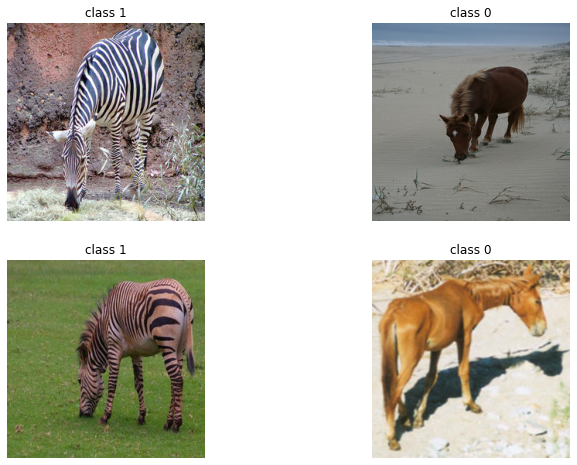

In [10]:
def display_imgs():
    """
    A helper function that displays a four images from the horse2zebra cycle gan dataset, two for each class.
    """
    fig, ax = plt.subplots(2,2, figsize = (12, 8)); ax = ax.flatten()

    horse_imgs, zebra_imgs = [], []
    for i, (image, label) in enumerate(trainA.take(2)):
        plt.sca(ax[2*i + 1])
        plt.imshow(image)
        plt.title(f"class {label}")
        plt.axis('off')
        horse_imgs.append(image)

    for i, (image, label) in enumerate(trainB.take(2)):
        #plt.sca() switches the current pyplot
        plt.sca(ax[(i - 1) * 2])
        plt.imshow(image, cmap = "twilight_r")
        plt.title(f"class {label}")
        plt.axis('off')
        zebra_imgs.append(image)
    print('image size: ', image.shape)
    
    return horse_imgs, zebra_imgs
horse_imgs, zebra_imgs = display_imgs()

(256, 256, 3)


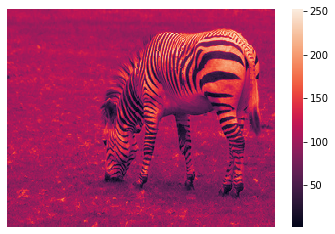

In [11]:
import seaborn as sns
print(zebra_imgs[0].shape)
sns.heatmap(zebra_imgs[0][:,:,0])
plt.axis('off');

#cool right? What are we forgetting?

What is wrong with our implimentation so far? Why?

In [12]:
#you can combine tensorflow datasets with a simple concatenation!
ds_train = trainA.concatenate(trainB)
ds_test  = testA.concatenate(testB)

H = W = 256//2
AUTOTUNE = tf.data.experimental.AUTOTUNE

def normalize_img(img, label):
    return tf.cast(img, tf.float32)/255.0, label

def resize_img(img, label):
    return tf.image.resize(img, size=[H, W]), label

ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE).map(resize_img, AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE).map(resize_img, AUTOTUNE)

In [13]:
#lets extract the normalized class specific images from the tensorflow dataset
horse_imgs, zebra_imgs = [], []
for img, label in ds_train.as_numpy_iterator():
    
    if not label: #if label != 0
        horse_imgs.append(img)
    else:
        zebra_imgs.append(img)

In [14]:
act = {"activation" : "relu", "strides" : 2}

model = Sequential()
#model.add(Input(shape = (H, W, 3)))
model.add(Conv2D(input_shape = (H, W, 3), filters = 16, kernel_size = (2,2), 
                 strides = 1, activation = 'relu', padding = "same"))
model.add(Conv2D(input_shape = (H, W, 3), filters = 16, kernel_size = (3,3), **act))
model.add(Conv2D(filters = 17, kernel_size = (3,3), **act))
model.add(Conv2D(filters = 32, kernel_size = (2,2), **act))
model.add(Conv2D(filters = 64, kernel_size = (2,2), **act))

model.add(Flatten())
model.add(Dense(25))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'bce', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 17)        2465      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        2208      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                7

In [15]:
BATCH_SIZE = 256
EPOCHS = 15

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


mc = ModelCheckpoint(DATA_DIR + "cnn1/cp.ckpt", monitor='val_loss', save_best_only=True, save_weights_only=False)

if not MODELS_TRAINED:
    history = model.fit(ds_train.cache().shuffle(buffer_size = ds_train.cardinality()).batch(BATCH_SIZE).prefetch(AUTOTUNE),#.map(augment, num_parallel_calls=AUTOTUNE),
                        validation_data=ds_test.cache().shuffle(buffer_size = ds_test.cardinality()).batch(BATCH_SIZE).prefetch(AUTOTUNE),
                        epochs=EPOCHS, callbacks = [es]#, mc]
        )
    plot_loss(history)
    
    #save the model
    model.save(DATA_DIR + 'cnn1')
else:
    #load the model
    model = tf.keras.models.load_model(DATA_DIR + 'cnn1')

    # Check its architecture
    model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 17)        2465      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        2208      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                7

In [16]:
#why does this have 4 dimensions?
model.layers[1].weights[0].shape

TensorShape([3, 3, 16, 16])

In [17]:
#define a new model with the layer we want to examine extracted.
model_ = Model(inputs=[model.input], outputs=[model.layers[0].output])

In [18]:
zebra_img = tf.expand_dims(zebra_imgs[0], axis = 0)
horse_img = tf.expand_dims(horse_imgs[0], axis = 0)

#COMMENT EXPLAINING WHY WE DO THE TRANSPOSE
zebra_layer0_feature_maps = model_.predict(zebra_img)[0,:,:,:]
horse_layer0_feature_maps = model_.predict(horse_img)[0,:,:,:]

#### Visualizing feature maps

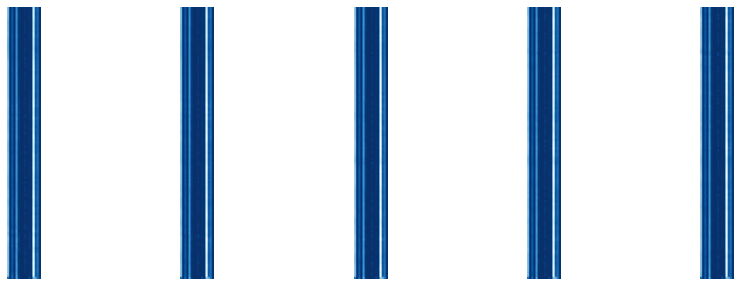

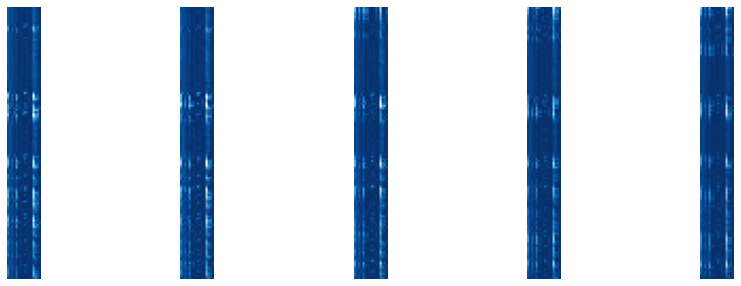

In [19]:
def quick_display(np_arr):
    fig, ax = plt.subplots(1,5, figsize = (15,5))
    ax = ax.ravel()
    for i in range(5):
        plt.sca(ax[i])
        plt.imshow(np_arr[i,:,:], cmap = 'Blues_r')
        plt.axis('off')

print()
quick_display(zebra_layer0_feature_maps)
quick_display(horse_layer0_feature_maps)

What went wrong?

In [20]:
print(zebra_layer0_feature_maps.shape)
print(zebra_layer0_feature_maps.transpose((2,0,1)).shape)

(128, 128, 16)
(16, 128, 128)


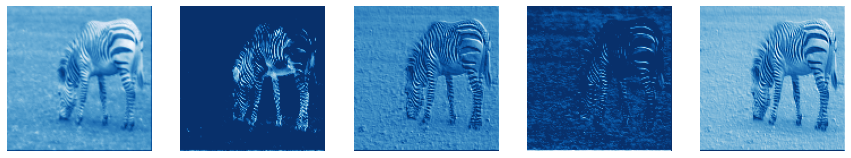

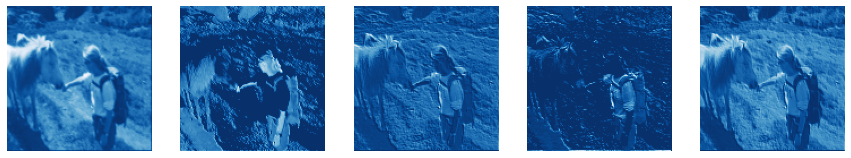

In [21]:
def quick_display(np_arr, title = None):
    fig, ax = plt.subplots(1,5, figsize = (15,5))
    ax = ax.ravel()
    for i in range(5):
        plt.sca(ax[i])
        plt.imshow(np_arr[:, :, i], cmap = 'Blues_r')
        plt.axis('off')
        if title and i == 2:
            plt.title(title)

quick_display(zebra_layer0_feature_maps)
quick_display(horse_layer0_feature_maps)


$\bullet$ <font color='blue'>what can we say about the above feature maps? What is our network detecting?</font>

$\bullet$ <font color='blue'>Does the performance of model suggest our network has learned rotational invariance? why? </font>

<a id='BO1'></a>

## Break Out Room 1

<a id='BO1A'></a>
Consider these 3 sets of filters from VGG16:

A             |  B         | C            
:-------------------------:|:-------------------------:|:-------------------------:
<img src='fig/q7_3a.png'>   |  <img src='fig/q7_3c.png'> | <img src='fig/q7_3b.png'>

Can you arrange them in order representing their place in the network(Shallow --> Deep)?

<a id='BO1B'></a>

### Problem 2

Extract some feature maps from the network above's deeper layers. Try to interpret what you find.

***To load the exercise please uncomment and run the cell below. The solutions are in the following cell. Don't open them until you've attempted the problem with your group!***

In [ ]:
# %load exercises/ex1.py
#exercise: try to print out multiple maps using the quick_display function

#disable warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

zebra_img = zebra_imgs[0]
horse_img = horse_imgs[0]

#expand the dimensions of the images of zebra_img and horse_img (can also be done with reshape)
zebra_img_4d = np.expand_dims(..., axis = ...)
horse_img_4d = np.expand_dims(..., axis = ...)

n_layers = 3

#solutions
for i in range(n_layers):
    
    #choose the model input and output
    input_layer = ...
    output_layer = ...
    
    #modify the model
    model_ = Model(inputs=[input_layer], outputs=[output_layer])
    
    #make a model prediction
    zebra_layer_i_feature_maps = model_.predict(...)
    horse_layer_i_feature_maps = model_.predict(...)
    
    #plot the feature maps (don't forget to convert them back to 3d before plotting!)
    quick_display(..., title = f'zebra layer {i}')
    quick_display(..., title = f'horse layer {i}')

#re-enable warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

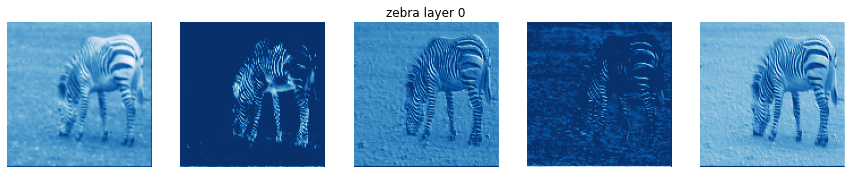

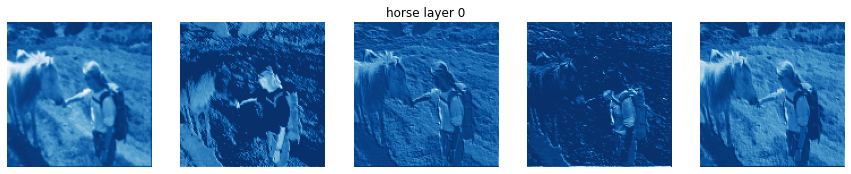

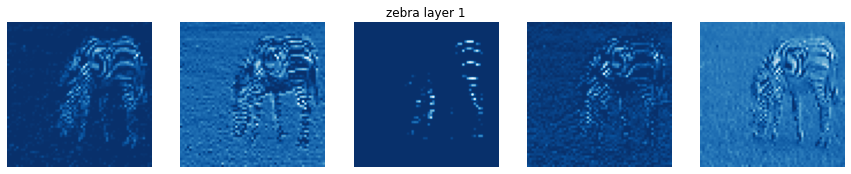

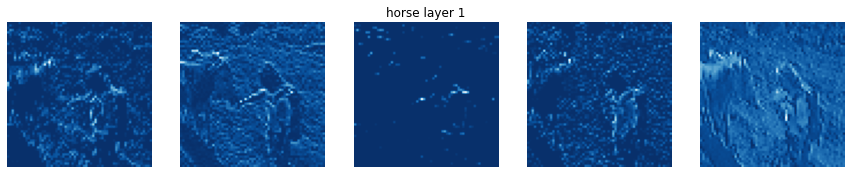

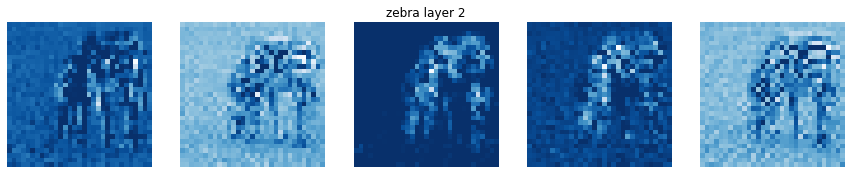

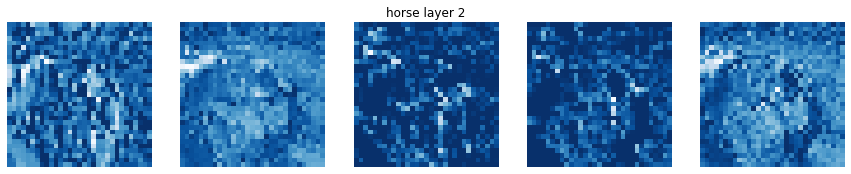

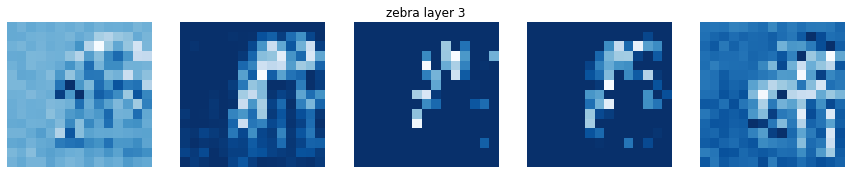

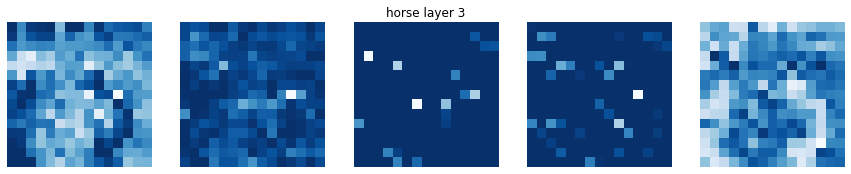

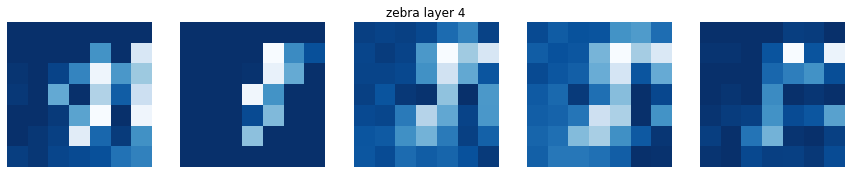

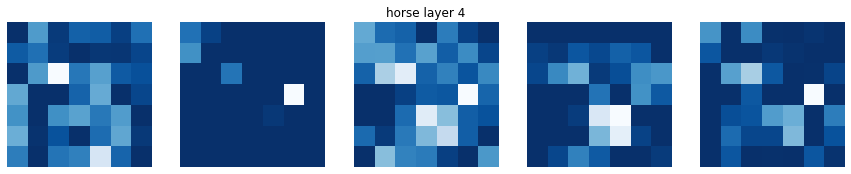

In [24]:
# %load sol/bo1_sol.py
#solutions to breakout room 1

#disable warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#expand the dimensions of the images — can also be done with .reshape(-1, *zebra_imgs[0].shape)
zebra_img_4d = np.expand_dims(zebra_imgs[0], axis = 0)
horse_img_4d = np.expand_dims(horse_imgs[0], axis = 0)

n_layers = 5

#solutions
for i in range(n_layers):
    
    #choose the model input and output
    input_layer = model.input
    output_layer = model.layers[i].output
    
    #modify the model
    model_ = Model(inputs=[input_layer], outputs=[output_layer])
    
    #make a model prediction
    zebra_layer_i_feature_maps = model_.predict(zebra_img_4d)
    horse_layer_i_feature_maps = model_.predict(horse_img_4d)
    
    #plot the feature maps
    quick_display(zebra_layer_i_feature_maps[0,:,:,:], title = f'zebra layer {i}')
    quick_display(horse_layer_i_feature_maps[0,:,:,:], title = f'horse layer {i}')

#re-enable warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

<a id='attention'></a>

# Attention

**Neural network attention** is analogous to cognitive attention. Attention highlights the important parts of the input data and fades out the rest.

This concept is helpful in understanding the topic of saliency maps.


## What do you notice about the way that the network was discriminating between classes?

$\bullet$ This image is from this [***paper***](https://arxiv.org/abs/1602.04938) where the task was to classify huskies and wolves.

$\bullet$ For each pair of images we have the original image at left and an image with the unimportant pixels occluded at right.

<img src='https://cdn-images-1.medium.com/max/1600/0*G9Pok8mnm_lCHxda.png'>

<a id='salience'></a>
## Image Class specific Saliency Maps

**Salience**: The quality of being particularly noticable or important; prominance. (Definition from Oxford Languages)

In general we can think of saliency maps as measuring:

$$\frac{\partial{\text{ output (for example an output class or regression value)}}}{\partial{\text{ input}}}$$

More formally we can query our CNN about the **spatial support** of a particular class in a given image. In a [groundbreaking paper from the Visual Geometry group of Oxford in 2014 by Simonyan et al.](https://arxiv.org/abs/1312.6034) given an image $I_0$, a class $c$, and a classification with the class score function $S_c(I)$ we can rank the pixels of the image based on their effect on the score $S_c(I_0)$.

For example, given $w_c$ and $b_c$ are class specific weight and bias scores of the model, imagine that the score function were simply

$$S_c(I_0) = w_c^T I + b_c$$

where  then it is clear that **"the magnitude of the elements of *$w_c$* defines the importance of the corresponding pixels of $I$ for class $c$ ".**

$$ \frac{\partial S_c}{\partial I} \propto w_c^T$$

CNNs in reality have a highly non-linear and complex error function and a much more complex derivative. However, using the first term of a taylor series approximation allows us to describe the error function in the neighborhood of an image $I_0$ simply by writing:

$$ S_c (I) \approx w_c^T I_0 + b$$


$$w_c = \left.\frac{\partial S_c}{\partial I}\right |_{I_0}$$

Notice that $w_c$ now is defined as the derivative of $S_c$ with respect to the image $I$ evaluated at the point $I_0$.

Steps to compute saliency map $ \mathcal{M} \in \textrm{IR}^{nxm}$ for input image I with height $n$ and width $m$:
1. We find the derivative $w_c$ by backpropagation, we rearrange the vector. 

2. We then take the absolute value, so the map at pixel at row i and column j can be computed as $M_{ij} = \left|w_{h(i,j)}\right|$ where h(i,j) is the index.

3. For a color image (3 channels) a common practice is to take the maximum across the channels for each pixel ie $M_{ij} = Max_c\left|w_{(i,j,c)}\right|$
 
Some further things to note:

$\bullet$ In normal backpropagation we take the derivative of the error with respect to the weights and use that gradient to adjust the weights. Here instead we take the derivative with respect to the input image.

$$\text{Backpropagation: } \frac{\partial{S_c}}{\partial w_{jk}^{l}} \text{ vs Vanilla Saliency Map: }\frac{\partial S_c}{\partial I}$$


$\bullet$ ***An interpretation of computing the image-specific class saliency using the class score derivative is that the magnitude of the derivative indicates which pixels need to be changed the least to affect the class score the most.***

$\bullet$ The magnitudes of these derivatives can indicate the location of the class and saliency maps have applications in **semantic segmentation**.

<img src='https://analyticsindiamag.com/wp-content/uploads/2018/07/sal-1.jpg' width = 700> 

<a id='gradcam'></a>
## GradCam

This explanation was adapted from this useful link: https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

Also, attached is the original paper on Grad Cam: https://arxiv.org/pdf/1610.02391.pdf

One problem with saliency maps is that they can be very noisy. Other techniques that were developed were cam, guided backpropagation, and finally gradcam.

Each feature map in the last convolution layer can be conceptualized as describing a classification feature. Let the final feature map be represented by $A^k \in \mathrm{IR}^{n x m}$, then

$$y = f(A^1, ..., A^{64})$$

Grad Cam assumes that this final feature map regionally reveals how the model discriminates.

For an individual class, such as a cathedral, certain features (like a steeple or stained glass windows) might identify that class more than another class like Golden Retriever. So instead of taking a simple linear combination of the final feature maps we take a weighted combination

$$\mathcal{L}_{\text{Grad-Cam}} = \sum_{k} a_k^c A^k$$

The gradient of a specific class score with respect to the $k^\text{th}$ final feature map measures "the linear effect of the $(i,j)^\text{th}$ pixel on the $c^\text{th}$ class score".

Grad-Cam assumes an average gradient score for the weights of the feature map:

$$a_k^c = \frac{1}{uv}\sum_{i = 1}^ n\sum_{j=1}^m \frac{\partial S_c}{\partial A_{(i,j)}^k}$$

Finally to calculate the Grad-Cam score we pass the weighted linear combination of feature maps through a relu because we only care about positive class correlation, not negative. For example want to know which parts of the image positively contributed to the score of zebra (is it looking at the stripes?) vs areas of the image which negatively impacted this score.

$$\mathcal{L}_{\text{Grad-Cam}} = \text{ReLU} \left(\sum_{k} a_k^c A^k\right) \in \mathcal{R}^{m x n}$$

$n$ and $m$ represent the height and width of the final feature maps. Finally, we upsample the final feature maps to the size of the input image!


In [25]:
act = {"activation" : "relu", "strides" : 2}

#lets redefine our model with 2 output nodes instead of one so we can investigate the saliency maps of both classes

if not MODELS_TRAINED:
    model = Sequential([
        Input(shape = (H, W, 3)),
        Conv2D(filters = 16, kernel_size = (2,2), strides = 1, activation = 'relu', padding = "same"),
        Conv2D(filters = 16, kernel_size = (3,3), **act),
        Dropout(0.005), #dropout between convolution layers acts as bernoulli noise, 
                      # which is not like standard fnn dropout
        Conv2D(filters = 17, kernel_size = (3,3), **act),
        Conv2D(filters = 22, kernel_size = (2,2), **act),
        Conv2D(filters = 44, kernel_size = (2,2), **act),
        Flatten(),
        Dense(25),
        Dropout(0.05),
        Dense(10),
        Dropout(0.05),
        Dense(2, activation = 'softmax')])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    BATCH_SIZE = 128
    EPOCHS = 25

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(ds_train.cache().shuffle(buffer_size = ds_train.cardinality(), seed = 109).batch(BATCH_SIZE).prefetch(AUTOTUNE),#.map(augment, num_parallel_calls=AUTOTUNE),
                    validation_data=ds_test.cache().shuffle(buffer_size = ds_test.cardinality(), seed = 109).batch(BATCH_SIZE).prefetch(AUTOTUNE),
                    callbacks=[es], epochs=EPOCHS,
    )
    plot_loss(history)
    
    #save the model
    model.save(DATA_DIR + 'cnn2')
else:
    #load the model
    model = tf.keras.models.load_model(DATA_DIR + 'cnn2')

# Check the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 17)        2465      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 22)        1518      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 44)          3916      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2156)             

<a id='BO2'></a>

## Break Out Room 2

Here you will try to implement a function that creates saliency maps for your desired output.

1. Complete the prepare image and model modifier helper functions

2. Complete the saliency graphs function

3. View the saliency maps

4. Discuss what these saliency maps tell us about how the model is training

In [ ]:
# Define a function here to replace "Binary Cross Entropy" 
# of the final dense layer with "linear" as we want the class scores, not the class
def prepare_image(img):
    
    #add a fourth dimension to your image to enable it to be passed to model.predict:
    
    img_expanded_dims = ...
    return img_expanded_dims

def model_modifier(m):
    m.layers[...].activation = ...

def saliency_graphs(model, img, positive_gradients = False):
    
    fig, ax = plt.subplots(1,3, figsize = (14,3))
    
    # Create Saliency object. 
    saliency = Saliency(model, model_modifier)

    # input image that is pre-processed
    input_image =  prepare_image(...) 

    # predict on the input image
    y_pred = model.predict(...)
    n_classes = 2
    ax[0].imshow(img[0])
    
    cmap_dict = {0 : "Reds", 1 : "Greens"}
    
    for i in range(2):
        
        # Define loss function for the class label.
        # The 'output' variable refer to the output of the model. 
        # This will be different for softmax activations and regression!
        
        loss = lambda output: tf.keras.backend.mean(...)

        # Generate saliency map with smoothing. Smoothing reduces noise in the Saliency map
        # smooth_samples is the number of calculating gradients iterations
        
        saliency_map = saliency(loss, ..., smooth_samples=20)
        
        #to only see positive gradients:
        if positive_gradients:
            locs = saliency_map > 0
            
        #normalize
        saliency_map = normalize(saliency_map)
        
        if positive_gradients:
            saliency_map[locs] = 0
        
        ax[i+1].imshow(saliency_map[0,...], cmap = cmap_dict[i])
        if i == 0:
            ax[i+1].set_title("Horse saliency map")
        else:
            ax[i+1].set_title("Zebra saliency map")
    #show original image
    ax[0].imshow(img)

In [27]:
# %load sol/bo2_sol.py
#### Solution

class_dict = {0: "horse", 1: "zebra"}

# Define a function here to replace "sigmoid" of the final dense layer with "linear" 
# as we want the class scores, not the class

def prepare_image(img):
    img_expanded_dims = tf.expand_dims(img, axis=0)
    return img_expanded_dims

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# Defining a function to generate saliency graphs for the 2 predicted classes
def saliency_graphs(model, img, n_classes = 2, positive_gradients = False):
    """
    plot saliency maps
    
    Arguments:
        model: The trained CNN for which you want to plot gradients
        img: the input image that you want to generate saliency maps for
        n_classes (int): the number of classes in your dataset
        positive gradients (bool): if True then only plot the vanilla saliency map for the positive gradients
    """
    
    fig, ax = plt.subplots(1,5, figsize = (14,3))

    # Create Saliency object
    saliency = Saliency(model, model_modifier)
    gradcam = Gradcam(model, model_modifier)

    # pre-process img (expand dims)
    input_image =  prepare_image(img)

    # predict on the input image
    y_pred = model.predict(input_image)
    col = "red" if y_pred.argmax() == 1 else "green"
    
    cmap_dict = {0 : "Reds", 1 : "Greens"}
    
    print("predicted class:", class_dict[y_pred.argmax()])
    
    #combined_saliency_map
    combined_saliency_map = np.zeros((128,128,3))
    
    for i in range(n_classes):

        # Define loss function for the class label.
        # The 'output' variable refer to the output of the model. 
        loss = lambda output: tf.keras.backend.mean(output[:,i])
        
        # Generate saliency map with smoothing. Smoothing reduces noise in the Saliency map
        # smooth_samples is the number of calculating gradients iterations
        saliency_map = saliency(loss, input_image, smooth_samples=20)
        
        #to only see positive gradients:
        if positive_gradients:
            locs = saliency_map > 0
        
        saliency_map = normalize(saliency_map)
        
        if positive_gradients:
            saliency_map[locs] = 0
        
        ax[i+1].imshow(saliency_map[0,...], cmap = cmap_dict[i])
        
        if i == 0:
            ax[i+1].set_title("Horse saliency map")
        else:
            ax[i+1].set_title("Zebra saliency map")
        combined_saliency_map[:,:,i] = saliency_map
        
    #show original image
    ax[0].imshow(img)
    
    #ploting the combined saliency map...
    #note that relative color intensity is not particularly meaningful (red vs green)
    #because we normalized the saliency maps before concatenating them into rbg.
    ax[3].imshow(img, alpha = 0.3)
    ax[3].imshow(combined_saliency_map, alpha = 0.96)
    ax[3].set_title("combined Saliency map")
    
    #gradcam for zebra class
    #we want the grad gam to be taken w.r.t. the predicted class:
    grad_cam_loss = lambda output: tf.keras.backend.mean(output[:, y_pred.argmax()])
    grad_heatmap = normalize(gradcam(grad_cam_loss, input_image))
    
    ax[4].imshow(img)
    ax[4].imshow(grad_heatmap[0,...], cmap = "viridis", alpha = 0.6)
    ax[4].set_title("Grad Cam for pred class")
    
    #turn off the axis ticks for all images
    [ax[i].axis('off') for i in range(5)]

predicted class: zebra
predicted class: zebra
predicted class: zebra


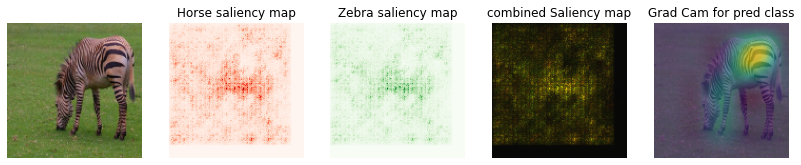

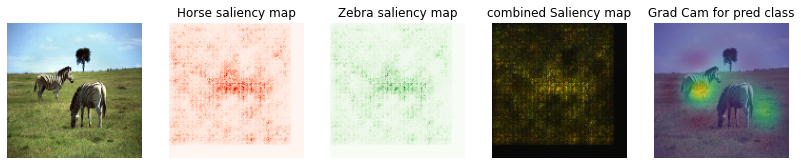

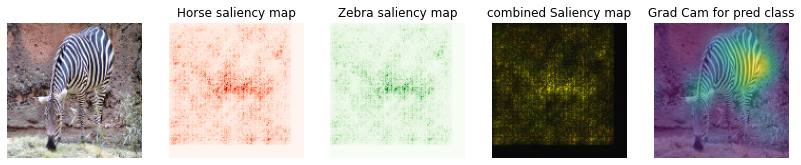

In [28]:
#disable warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#run this after you have repaired the function above or loaded and executed the solution cell.
for i in range(3):
    saliency_graphs(model, zebra_imgs[i].reshape(128,128,3))

predicted class: horse
predicted class: horse
predicted class: horse


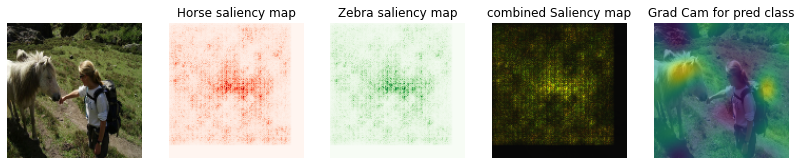

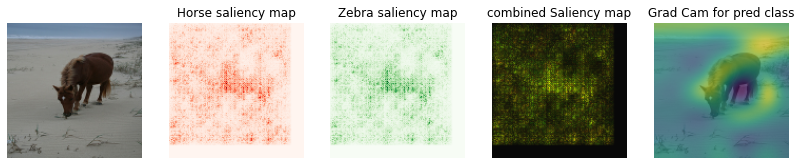

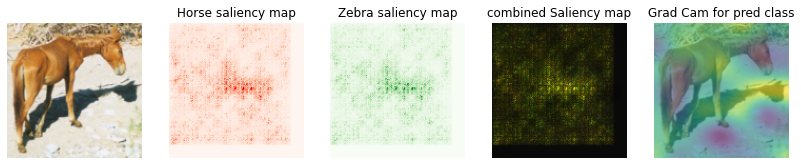

In [29]:
#run this after you have repaired the function above or loaded and executed the solution cell.
for i in range(3):
    saliency_graphs(model, horse_imgs[i].reshape(128,128,3))

#re-enable warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

In [ ]:
#for i in range(1):
#    saliency_graphs(model, horse_imgs[i].reshape(128,128,3), positive_gradients = False)
#    saliency_graphs(model, horse_imgs[i].reshape(128,128,3), positive_gradients = True)
#    saliency_graphs(model, zebra_imgs[i].reshape(128,128,3), positive_gradients = False)
#    saliency_graphs(model, zebra_imgs[i].reshape(128,128,3), positive_gradients = True)

<a id='sota'></a>
# Some State of the Art Architectures and associated papers

This is a very <a href='https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d'> nice article</a> that walks through 10 modern CNN  architectures.

<img src='https://miro.medium.com/max/1400/1*n16lj3lSkz2miMc_5cvkrA.jpeg'>

Some important CNN models architecture papers:

LeNet (1998) 
    <a href='http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf'>
    Gradient-Based Learning Applied to Document Recognition
    </a>
    
AlexNet (2012) <a href='https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf'>
ImageNet Classification with Deep Convolutional Neural Networks</a>

VGG (2014) <a href='https://arxiv.org/abs/1409.1556'> Going Deeper with Convolutions</a>

Inception (2015) <a href='https://arxiv.org/abs/1409.4842'> Going Deeper with Convolutions</a>

ResNet-50 (2015) <a href ='https://arxiv.org/abs/1512.03385'> Deep Residual Learning for Image Recognition </a>

MobileNet (2017) <a href='https://arxiv.org/abs/1704.04861'> MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications</a>

<a id='deepdream'></a>
# Advanced visualization tools and techniques: Deep Dream and Style Transfer  from Google

Google DeepDream (created by Alexander Mordvintsev, a google data scientist and engineer) creates images that try to maximally exite a given output nueron. For example certain nuerons in the deeper layers of the network might be responsible for detecting faces or cathedrals.

Its visualizations were originally used to help understand the emergent structure of the convolutional neural network.

"Initially it was invented to help scientists and engineers to see what a deep neural network is seeing when it is looking in a given image. Later the algorithm has become a new form of psychedelic and abstract art." To see more visit their <a href="https://deepdreamgenerator.com/"> website </a> or view the advanced section

<img src='http://i.imgur.com/e5cy8HS.gif' width = 500>

<img src='https://b2h3x3f6.stackpathcdn.com/assets/landing/img/blend/horizontal/dd.jpg' width = 500>

<img src='https://b2h3x3f6.stackpathcdn.com/assets/landing/img/blend/horizontal/ds_1.jpg' width = 500>


<a id='tl'></a>
# Bonus Material: Gradient Tap

`tf.GradientTape` allows us to track calculate gradients with respect to variables of our choice! It is part of the tensorflow automatic differentiation API.

The tape will automatically "watch" trainable tf.Variables. Otherwise we can use `tape.watch`

Here is an additional tutorial: https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

**From the <a href='https://www.tensorflow.org/guide/autodiff'> documentation:** </a>
"TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variables`. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation."


In [30]:
#Impliment saliency map with gradient tape
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 17)        2465      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 22)        1518      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 44)          3916      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2156)             

In [ ]:
# In this example we generate a saliency map using gradient tape.
# first we get a modified model copy:
model_ = Model(inputs=[model.input], outputs=[model.layers[-1].output])

#specifically we modify the last layer to have a linear activation like before
model_.output.activation = tf.keras.activations.linear

#now select the input image
img_ = zebra_imgs[3]

image = tf.expand_dims(img_, axis = 0)

with tf.GradientTape() as tape:
    
    #we tell the tape to watch the four dimensional input image tensor.
    tape.watch(image)
    
    pred = model_(image, training=False) #training = false will prevent our model from using dropout
    zebra_prediction = pred[0, 1]
    loss = zebra_prediction

#calculate the gradient of the loss with respect to the input image
dloss_dimage = tape.gradient(loss, image)
print(dloss_dimage.shape)

def process_gradient(grads_):
    """
    This helper function takes the absolute gradients, finds the maximum gradient across the tree channels,
    and then normalizes the result. This is specific to the method of calculating a saliency map.
    """
    abs_grads = tf.math.abs(grads_)[0,...]

    grads_max = np.max(abs_grads, axis=2)

    norm_grads_2d = normalize(grads_max)
    return norm_grads_2d

#lets plot the saliency map!
fig, ax = plt.subplots(1, 3, figsize=(16,5))

ax[0].imshow(process_gradient(dloss_dimage), cmap="Greens", alpha = 1)
ax[0].set_title("saliency map")
ax[1].imshow(img_)
ax[1].set_title("input image")
[ax.axis('off') for ax in ax]
plt.show()

In [ ]:
type(tf.GradientTape())